# GRANDATA - Test Técnico Data Engineer

## Objetivos del Test

1. **Calcular el monto total** de facturación por envíos de SMS
2. **Generar dataset** con los 100 usuarios de mayor facturación por SMS (incluyendo hash MD5)
3. **Crear histograma** de llamadas por hora del día

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GranData Test") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

spark.sparkContext._jsc.hadoopConfiguration().set(
    "mapreduce.fileoutputcommitter.marksuccessfuljobs", "false"
)

In [2]:
from pyspark.sql.functions import *


In [3]:
# data file paths
events_path = "work/data/events.csv.gz"
fsms_path = "work/data/free_sms_destinations.csv.gz"

In [4]:
events_df = spark.read.csv(events_path, header=True, inferSchema=True)
events_df.show(5)
events_df.printSchema()


+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
+----+-----+-------+---+--------+------+---------+--------------+
only showing top 5 rows

root
 |-- hour: integer (nullable = true)
 |-- calls: integer (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- sms: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)



In [5]:
# limpiar nulos o valores "NULL"
events_clean_df = events_df.filter(
    (col("id_source").isNotNull()) & 
    (col("id_destination").isNotNull()) &
    (col("id_source") != '') & 
    (col("id_destination") != '') &
    (col("id_source") != 'NULL') &
    (col("id_destination") != 'NULL')
)

# verificar el filtrado
print(f"originales: {events_df.count():,}")
print(f"limpios: {events_clean_df.count():,}")
print(f"eliminados: {events_df.count() - events_clean_df.count():,}")

originales: 1,000,000
limpios: 999,970
eliminados: 30


In [6]:
free_destinations_df = spark.read.csv(fsms_path, header=True, inferSchema=True)
free_destinations_df.show(10)
free_destinations_df.printSchema()
free_destinations_df.count()

+---+
| id|
+---+
|374|
|D52|
|861|
|5B0|
|4CA|
|465|
|048|
|D5B|
|FD6|
|2D3|
+---+
only showing top 10 rows

root
 |-- id: string (nullable = true)



200

In [7]:
# limpiar nulos o valores "NULL" en free_destinations_df
free_destinations_clean_df = free_destinations_df.filter(
    (col("id").isNotNull()) & 
    (col("id") != '') & 
    (col("id") != 'NULL')
)

# verificar el filtrado
print(f"originales: {free_destinations_df.count():,}")
print(f"limpios: {free_destinations_clean_df.count():,}")
print(f"eliminados: {free_destinations_df.count() - free_destinations_clean_df.count():,}")

originales: 200
limpios: 200
eliminados: 0


### Ejercicio 1
##### 1. **Calcular el monto total** que facturará el proveedor del servicio por envíos de sms.

Reglas de Facturación SMS
- *$0.0* → Destino gratuito
- *$1.5* → Regiones 1-5  
- *$2.0* → Regiones 6-9

In [8]:
# agrego columna de costo por sms
add_costs_df = events_clean_df.join(
    free_destinations_df,
    events_clean_df.id_destination == free_destinations_df.id,
    how='left')\
        .withColumn('sms_cost',
        when(col('id').isNotNull() , 0.0)
        .when(col('region').between(1, 5), 1.5)
        .when(col('region').between(6, 9), 2.0)
        .otherwise(0.0))

add_costs_df.show(10)


+----+-----+-------+---+--------+------+---------+--------------+---+--------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination| id|sms_cost|
+----+-----+-------+---+--------+------+---------+--------------+---+--------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|374|     0.0|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|374|     0.0|
|  11|    1|      3|  0|20211001|     6|      025|           374|374|     0.0|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|D52|     0.0|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|861|     0.0|
|  18|    0|      0|  1|20211001|     4|      90C|           5B0|5B0|     0.0|
|  13|    1|    618|  0|20211001|     9|      7AB|           4CA|4CA|     0.0|
|  16|    1|    172|  0|20211001|     9|      7AB|           4CA|4CA|     0.0|
|   6|    1|    208|  0|20211001|     9|      7AB|           4CA|4CA|     0.0|
|   5|    1|     66|  0|20211001|     9|      7AB|  

In [9]:
add_costs_df.groupBy("sms_cost") \
    .count() \
    .orderBy("sms_cost") \
    .show()

+--------+------+
|sms_cost| count|
+--------+------+
|     0.0| 49082|
|     1.5|411507|
|     2.0|539381|
+--------+------+



In [10]:
total_billing_amount = add_costs_df.agg(sum("sms_cost")).collect()[0][0]

print(f"RESPUESTA EJERCICIO 1")
print(f"Monto toal a facturar: ${total_billing_amount:,.2f}")

print("Facturacion por tipo de costo:")
add_costs_df.groupBy("sms_cost").agg(
    sum("sms_cost").alias("total_billed"),
    count("*").alias("sms_sent")
).orderBy("sms_cost").show()

RESPUESTA EJERCICIO 1
Monto toal a facturar: $1,696,022.50
Facturacion por tipo de costo:
+--------+------------+--------+
|sms_cost|total_billed|sms_sent|
+--------+------------+--------+
|     0.0|         0.0|   49082|
|     1.5|    617260.5|  411507|
|     2.0|   1078762.0|  539381|
+--------+------------+--------+



##### 2. **Generar un dataset** que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip.

In [11]:
# funcion udf para aplicar md5 al campo solicitado
def md5_hash(value):
    import hashlib
    return hashlib.md5(value.encode()).hexdigest()

In [12]:
# declaro udf
md5_udf = udf(md5_hash, StringType())

In [13]:
# df agrupado por id_source y agg.sum por sms_cost
df_user_billing = add_costs_df.groupBy("id_source").agg(
    sum("sms_cost").alias("total_billing"),
    count("*").alias("total_sms_sent")
)

df_user_billing.show(10)

+---------+-------------+--------------+
|id_source|total_billing|total_sms_sent|
+---------+-------------+--------------+
|      20E|        420.0|           238|
|      675|        344.0|           205|
|      829|        402.5|           226|
|      1DB|        415.5|           236|
|      F1B|        344.5|           214|
|      B05|        397.5|           234|
|      8FC|        384.0|           226|
|      1EE|        421.0|           252|
|      9AE|        386.0|           229|
|      A23|        367.5|           211|
+---------+-------------+--------------+
only showing top 10 rows



In [14]:
# obtener el top 100 de usuarios con md5 en id_source
df_user_billing_top_100 = df_user_billing \
    .withColumn("md5_id_source", md5_udf(col("id_source")))\
    .orderBy(desc("total_billing")).limit(100)

df_user_billing_top_100.select("id_source", "md5_id_source", "total_billing").show(10)

+---------+--------------------+-------------+
|id_source|       md5_id_source|total_billing|
+---------+--------------------+-------------+
|      4D3|911914c7729eedbdf...|      18573.0|
|      76D|bd180b7811395cbce...|      13508.0|
|      07E|14a0660ae2f5d1868...|       4070.0|
|      541|16c222aa19898e505...|       1707.0|
|      B86|bc97b32ee2abb9c18...|       1292.5|
|      3AE|6a57072949dbc409c...|       1026.0|
|      1BD|f5a45e33602ea62f9...|       1023.5|
|      3E0|e9d076deb3451cc49...|       1015.5|
|      D29|1b2e80021b5fc82bf...|        892.0|
|      E6F|159e1f3d6ff0e7c3c...|        714.5|
+---------+--------------------+-------------+
only showing top 10 rows



In [40]:
# escribir en parquet.gzip 
df_user_billing.write\
    .mode("overwrite")\
    .option("compression", "gzip")\
    .parquet("work/output/top_100_users/")

#### Resultado punto 2 en el folder "output/"

##### 3. **Graficar un histograma** de cantidad de llamadas que se realizan por hora del día.

In [16]:
import matplotlib.pyplot as plt

In [17]:
events_df.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- calls: integer (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- sms: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)



In [18]:
events_df.show(2)

+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
+----+-----+-------+---+--------+------+---------+--------------+
only showing top 2 rows



In [34]:
# df con agg de llamadas por hora y fecha
calls_by_hour = events_clean_df.groupBy("date","hour").agg(sum("calls").alias("total_calls")).orderBy("date","hour")
calls_by_hour.show(5)

+--------+----+-----------+
|    date|hour|total_calls|
+--------+----+-----------+
|20211001|   0|       6440|
|20211001|   1|       3222|
|20211001|   2|       1853|
|20211001|   3|       1514|
|20211001|   4|       1955|
+--------+----+-----------+
only showing top 5 rows



([<matplotlib.axis.XTick at 0xffff6910f8d0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

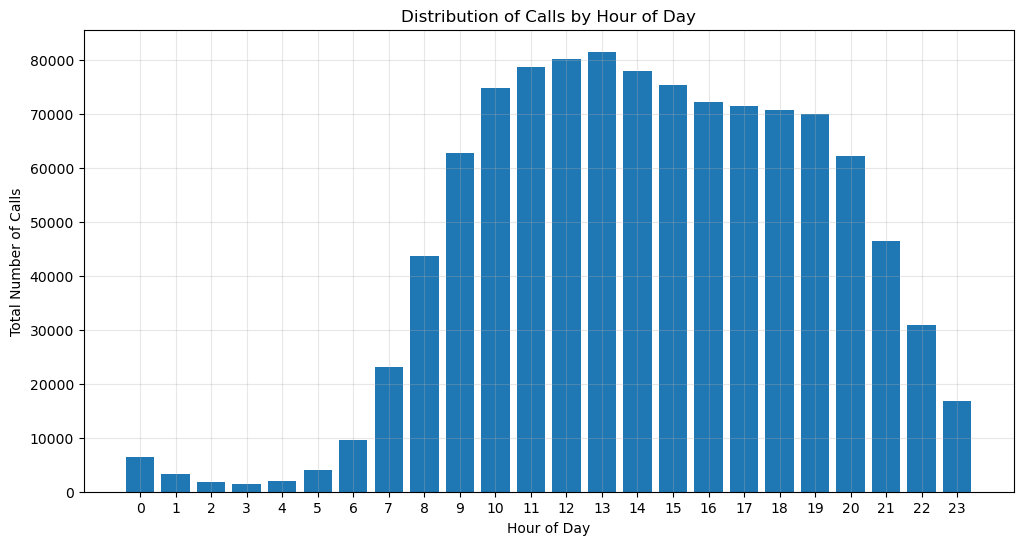

In [41]:
# hago el plot
calls_by_hour_pd = calls_by_hour.toPandas()

plt.figure(figsize=(12,6))
plt.bar(calls_by_hour_pd["hour"], calls_by_hour_pd["total_calls"])
plt.title("Distribution of Calls by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Number of Calls")
plt.grid(True, alpha=0.3)
plt.xticks(range(0,24))


In [42]:
plt.savefig('work/output/calls_histogram.png')
plt.close()